<a href="https://colab.research.google.com/github/aldyhassan/Literacy-Rate/blob/main/literacy_rate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Libraries

In [2]:
!pip install geopandas


In [1]:
!pip install plotly

In [3]:
!pip install pycountry pycountry-convert

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 43.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 234.7/234.7 kB 4.3 MB/s eta 0:00:00


In [4]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pycountry_convert as pc
import pycountry
import geopandas as gpd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots



#Importing Datasets

In [5]:
# Read data in Google Sheets
sheet_url = 'https://docs.google.com/spreadsheets/d/1R4jRHZhSYigNu1MdLfCwETYZLStZbipk7foXZ6unKVU/edit#gid=66416655'
sheet_url_trf = sheet_url.replace('/edit#gid=', '/export?format=csv&gid=')

# Open file
df = pd.read_csv(sheet_url_trf)
main_df = df.copy()
main_df.head()

,S.No,Country,Literacy Rate,Year
0,1,Andorra,1.0,2016.0
1,2,Armenia,1.0,2020.0
2,3,Australia,1.0,2020.0
3,4,Azerbaijan,1.0,2019.0
4,5,Barbados,1.0,2014.0


#Converting Year to timeseries

In [6]:
# Drop or fill non-finite values
main_df['Year'].dropna(inplace=True)

# Ensure all values are finite
main_df = main_df[np.isfinite(main_df['Year'])]

In [7]:
# Convert the year column to integer
main_df['Year'] = main_df['Year'].astype(int)

# Convert the year column to datetime
main_df['Year'] = pd.to_datetime(main_df['Year'], format='%Y')

# Display the year part of the datetime
main_df['Year'] = main_df['Year'].dt.year
main_df.head()

,S.No,Country,Literacy Rate,Year
0,1,Andorra,1.0,2016
1,2,Armenia,1.0,2020
2,3,Australia,1.0,2020
3,4,Azerbaijan,1.0,2019
4,5,Barbados,1.0,2014


#EDA

In [8]:
main_df['Literacy Rate'] = main_df['Literacy Rate'] * 100
main_df.head()

,S.No,Country,Literacy Rate,Year
0,1,Andorra,100.0,2016
1,2,Armenia,100.0,2020
2,3,Australia,100.0,2020
3,4,Azerbaijan,100.0,2019
4,5,Barbados,100.0,2014


In [9]:
# Verify country names
def verify_country_names(df):
    for country in main_df['Country']:
        if country not in [c.name for c in pycountry.countries]:
            print(f"Unrecognized country: {country}")

verify_country_names(main_df)

Unrecognized country: Moldova
Unrecognized country: Russia
Unrecognized country: United States of America
Unrecognized country: Czech Republic
Unrecognized country: Taiwan
Unrecognized country: Brunei
Unrecognized country: Venezuela
Unrecognized country: Turkey
Unrecognized country: Vietnam
Unrecognized country: Bolivia
Unrecognized country: Cape Verde
Unrecognized country: Ivory Coast
Unrecognized country: Iran
Unrecognized country: Laos
Unrecognized country: Syria
Unrecognized country: Tanzania
Unrecognized country: DR Congo
Unrecognized country: Republic of the Congo
Unrecognized country: Timor Leste
Unrecognized country: Guinea Bissau


In [10]:
# Correct any discrepancies manually
country_corrections = {
     'Moldova': 'Moldova, Republic of',
    'Russia': 'Russian Federation',
    'United States of America': 'United States',
    'Czech Republic': 'Czechia',
    'Ivory Coast': "Côte d'Ivoire",
    'DR Congo': 'Congo, The Democratic Republic of the',
    'Republic of the Congo': 'Congo',
    'Guinea Bissau': 'Guinea-Bissau',
    'Taiwan': 'Taiwan, Province of China',
    'Brunei': 'Brunei Darussalam',
    'Venezuela': 'Venezuela, Bolivarian Republic of',
    'Turkey': 'Türkiye',
    'Vietnam': 'Viet Nam',
    'Bolivia': 'Bolivia, Plurinational State of',
    'Cape Verde': 'Cabo Verde',
    'Iran': 'Iran, Islamic Republic of',
    'Laos': "Lao People's Democratic Republic",
    'Syria': 'Syrian Arab Republic',
    'Tanzania': 'Tanzania, United Republic of'
}

main_df['Country'] = main_df['Country'].replace(country_corrections)


In [11]:
verify_country_names(main_df)

Unrecognized country: Timor Leste


In [12]:
# Create a dictionary to map country names to continent names
country_continent_map = {}

# Populate the dictionary with known country to continent mappings
for country in pycountry.countries:
    country_alpha2 = country.alpha_2
    try:
        continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
        if continent_code in ['NA', 'SA']:
            continent_name = 'America'
        else:
            continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        country_continent_map[country.name] = continent_name
    except KeyError:
        # Skip countries that cannot be mapped
        continue

# Function to map country to continent using the dictionary
def country_to_continent(country_name):
    return country_continent_map.get(country_name, 'Unknown')

In [13]:
# Add a continent column
main_df['Continent'] = main_df['Country'].apply(country_to_continent)

# Manually correct the 'Unknown' continent for Timor Leste
main_df.loc[(main_df['Country'] == 'Timor Leste') & (main_df['Continent'] == 'Unknown'), 'Continent'] = 'Asia'

In [14]:
main_df['Continent'].value_counts()

Continent
Africa     53
Asia       44
America    35
Europe     30
Oceania    12
Name: count, dtype: int64

<ipython-input-15-6efae84e8da0>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(data=avg_literacy_continent, x='Continent', y='Literacy Rate', palette='viridis')
<ipython-input-15-6efae84e8da0>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45)


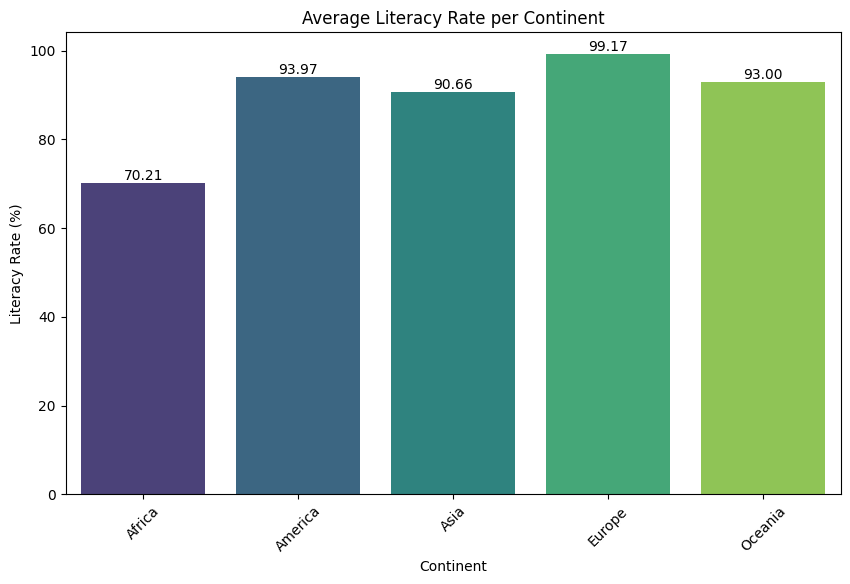

In [ ]:
# Calculate average literacy rate per continent
avg_literacy_continent = main_df.groupby('Continent')['Literacy Rate'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
barplot = sns.barplot(data=avg_literacy_continent, x='Continent', y='Literacy Rate', palette='viridis')
barplot.set_title('Average Literacy Rate per Continent')
barplot.set_xlabel('Continent')
barplot.set_ylabel('Literacy Rate (%)')
barplot.set_xticklabels(barplot.get_xticklabels(), rotation=45)

# Add labels
for container in barplot.containers:
    barplot.bar_label(container, fmt='%.2f')

plt.show()


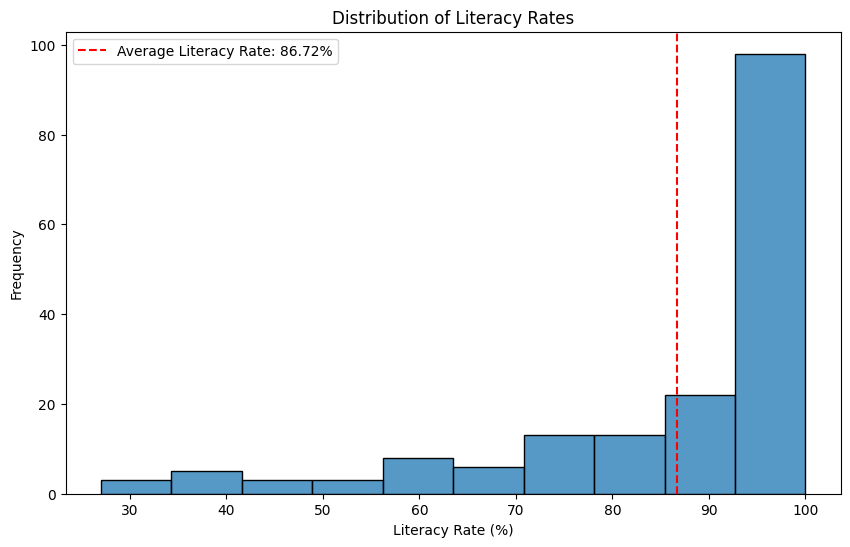

In [ ]:
# Overall literacy rate
overall_avg_literacy = main_df['Literacy Rate'].mean()

# Plotting
plt.figure(figsize=(10, 6))
histplot = sns.histplot(main_df['Literacy Rate'], bins=10, kde=False)
histplot.axvline(overall_avg_literacy, color='r', linestyle='--', label=f'Average Literacy Rate: {overall_avg_literacy:.2f}%')
histplot.set_title('Distribution of Literacy Rates')
histplot.set_xlabel('Literacy Rate (%)')
histplot.set_ylabel('Frequency')

plt.legend()
plt.show()

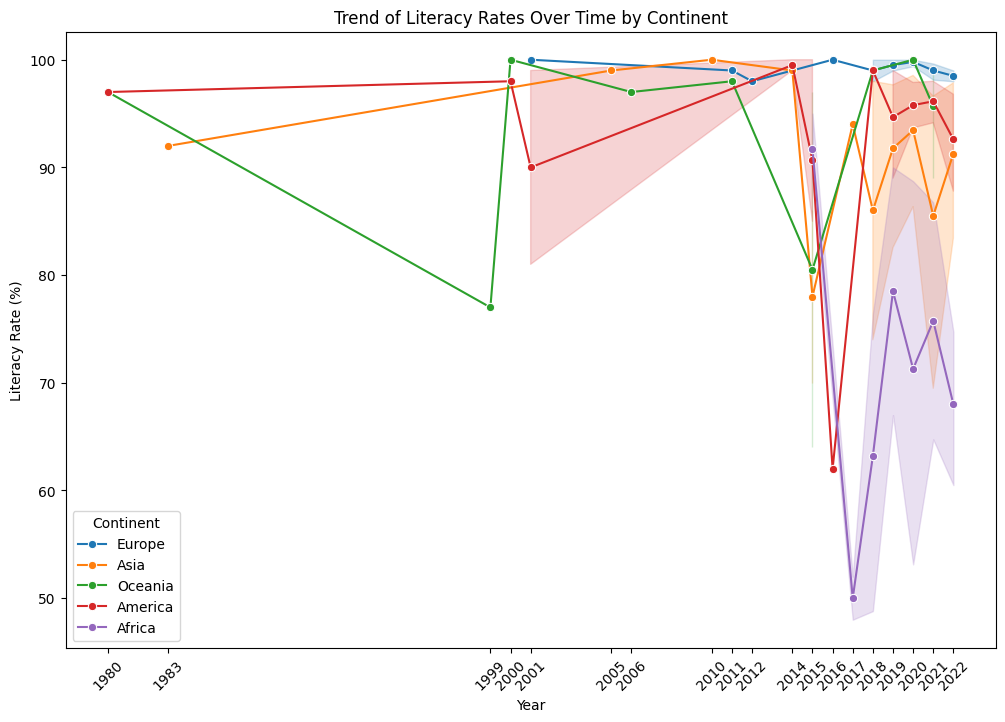

In [ ]:
# Trend analysis over time
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=main_df, x='Year', y='Literacy Rate', hue='Continent', marker='o')
lineplot.set_title('Trend of Literacy Rates Over Time by Continent')
lineplot.set_xlabel('Year')
lineplot.set_ylabel('Literacy Rate (%)')
lineplot.set_xticks(main_df['Year'].unique())
lineplot.set_xticklabels(main_df['Year'].unique(), rotation=45)

# Add labels
plt.legend(title='Continent')
plt.show()

<ipython-input-48-255095bb19db>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  top_barplot = sns.barplot(data=top_countries, x='Country', y='Literacy Rate', palette='viridis')
<ipython-input-48-255095bb19db>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  top_barplot.set_xticklabels(top_barplot.get_xticklabels(), rotation=45, ha='right')


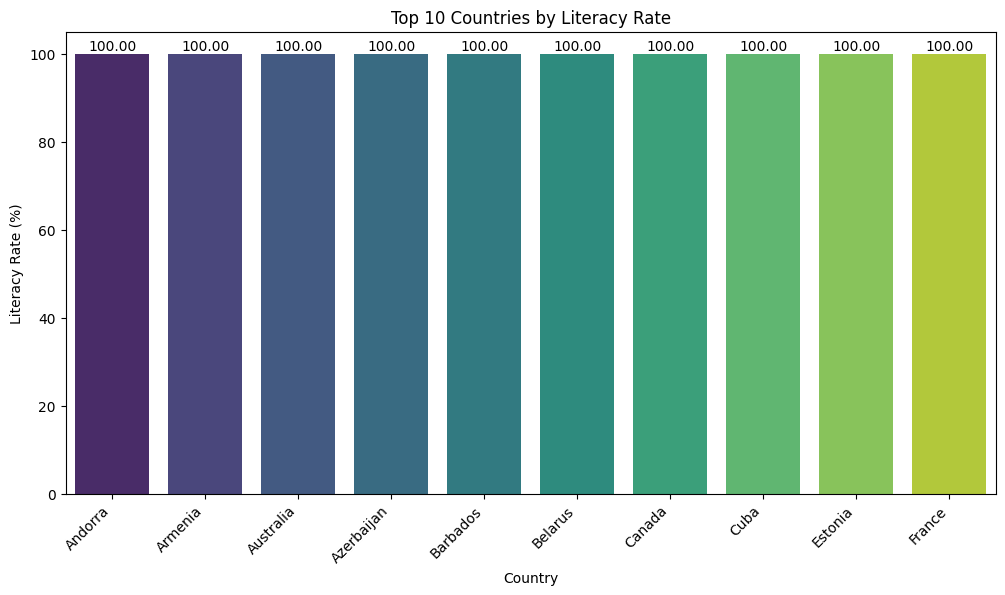

In [ ]:
# Top countries
top_countries = main_df.nlargest(10, 'Literacy Rate')

plt.figure(figsize=(12, 6))
top_barplot = sns.barplot(data=top_countries, x='Country', y='Literacy Rate', palette='viridis')
top_barplot.set_title('Top 10 Countries by Literacy Rate')
top_barplot.set_xlabel('Country')
top_barplot.set_ylabel('Literacy Rate (%)')
top_barplot.set_xticklabels(top_barplot.get_xticklabels(), rotation=45, ha='right')

# Add labels
for container in top_barplot.containers:
    top_barplot.bar_label(container, fmt='%.2f')

plt.show()

<ipython-input-46-13dda439f80c>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bottom_barplot = sns.barplot(data=bottom_countries, x='Country', y='Literacy Rate', palette='viridis')
<ipython-input-46-13dda439f80c>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  bottom_barplot.set_xticklabels(bottom_barplot.get_xticklabels(), rotation=45, ha='right')


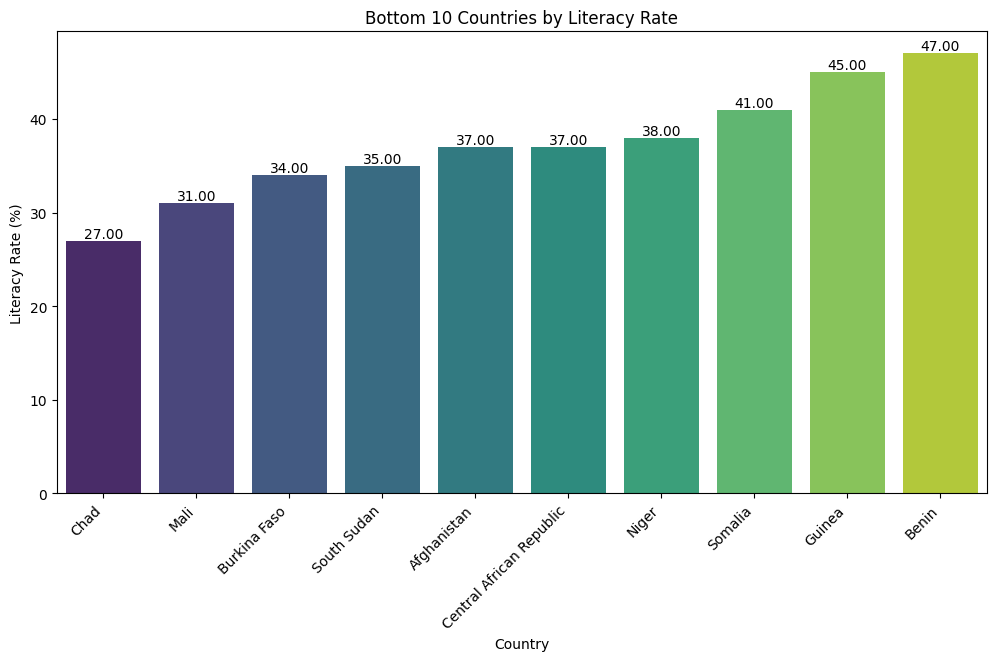

In [ ]:
# Bottom countries
bottom_countries = main_df.nsmallest(10, 'Literacy Rate')

plt.figure(figsize=(12, 6))
bottom_barplot = sns.barplot(data=bottom_countries, x='Country', y='Literacy Rate', palette='viridis')
bottom_barplot.set_title('Bottom 10 Countries by Literacy Rate')
bottom_barplot.set_xlabel('Country')
bottom_barplot.set_ylabel('Literacy Rate (%)')
bottom_barplot.set_xticklabels(bottom_barplot.get_xticklabels(), rotation=45, ha='right')

# Add labels
for container in bottom_barplot.containers:
    bottom_barplot.bar_label(container, fmt='%.2f')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


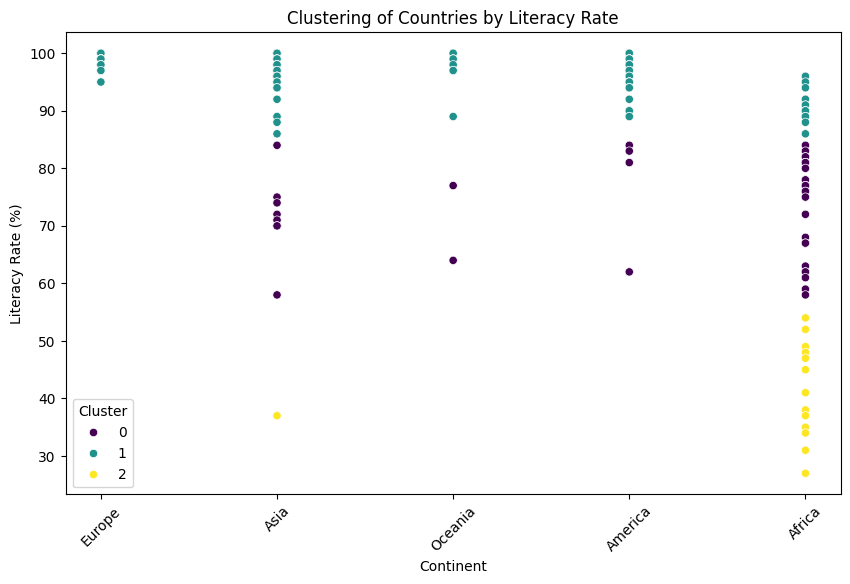

In [ ]:
from sklearn.cluster import KMeans

# Perform KMeans clustering
kmeans = KMeans(n_clusters=3)
main_df['Cluster'] = kmeans.fit_predict(main_df[['Literacy Rate']])

plt.figure(figsize=(10, 6))
sns.scatterplot(data=main_df, x='Continent', y='Literacy Rate', hue='Cluster', palette='viridis')
plt.title('Clustering of Countries by Literacy Rate')
plt.xlabel('Continent')
plt.ylabel('Literacy Rate (%)')
plt.xticks(rotation=45)
plt.show()

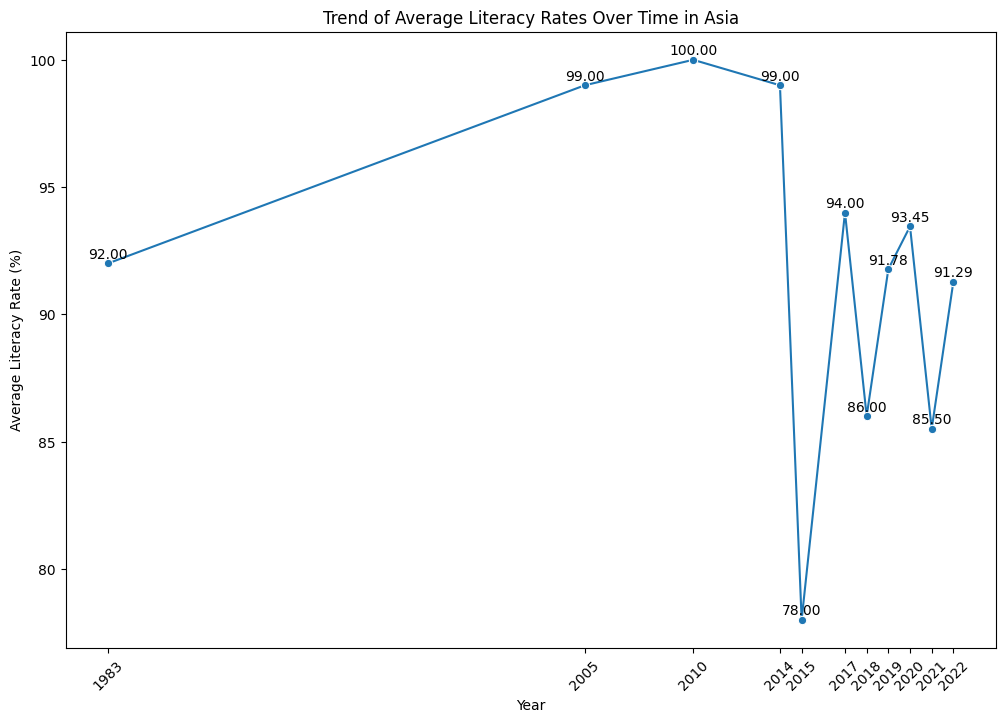

In [ ]:
# Filter data for Asia
asia_df = main_df[main_df['Continent'] == 'Asia']

# Calculate average literacy rate per year for Asia
asia_avg_literacy = asia_df.groupby('Year')['Literacy Rate'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=asia_avg_literacy, x='Year', y='Literacy Rate', marker='o')
lineplot.set_title('Trend of Average Literacy Rates Over Time in Asia')
lineplot.set_xlabel('Year')
lineplot.set_ylabel('Average Literacy Rate (%)')
lineplot.set_xticks(asia_avg_literacy['Year'].unique())
lineplot.set_xticklabels(asia_avg_literacy['Year'].unique(), rotation=45)

# Add labels
for x, y in zip(asia_avg_literacy['Year'], asia_avg_literacy['Literacy Rate']):
    plt.text(x, y + 0.2, f'{y:.2f}', ha='center')

plt.show()

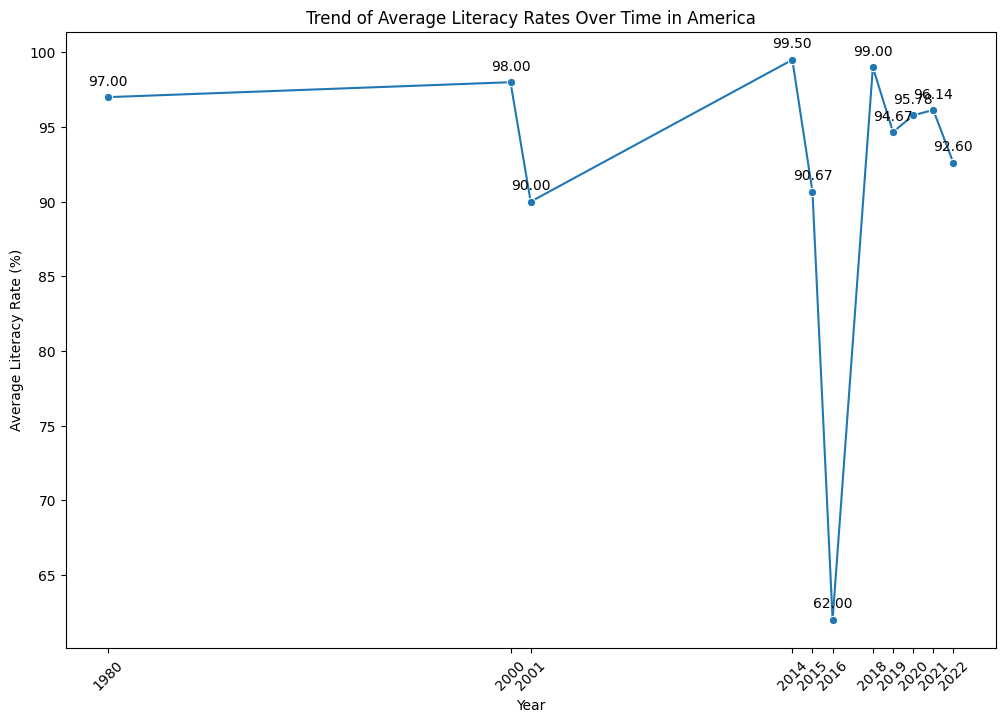

In [ ]:
# Filter data for America
america_df = main_df[main_df['Continent'] == 'America']

# Calculate average literacy rate per year for America
america_avg_literacy = america_df.groupby('Year')['Literacy Rate'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=america_avg_literacy, x='Year', y='Literacy Rate', marker='o')
lineplot.set_title('Trend of Average Literacy Rates Over Time in America')
lineplot.set_xlabel('Year')
lineplot.set_ylabel('Average Literacy Rate (%)')
lineplot.set_xticks(america_avg_literacy['Year'].unique())
lineplot.set_xticklabels(america_avg_literacy['Year'].unique(), rotation=45)

# Add labels
for x, y in zip(america_avg_literacy['Year'], america_avg_literacy['Literacy Rate']):
    plt.text(x, y + 0.8, f'{y:.2f}', ha='center')

plt.show()

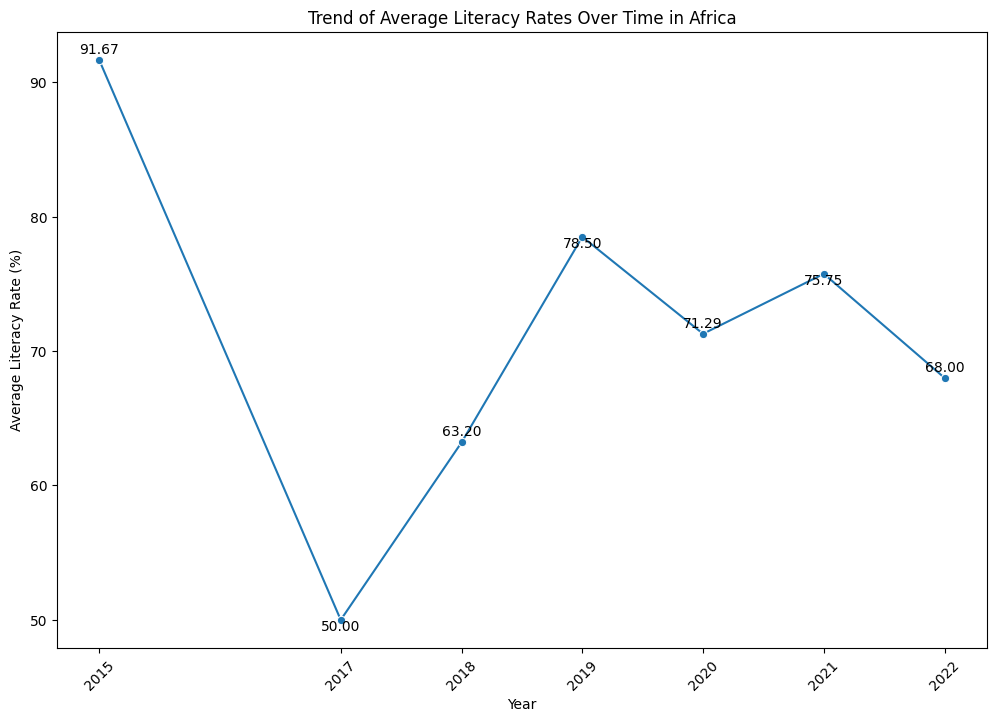

In [ ]:
# Filter data for Africa
africa_df = main_df[main_df['Continent'] == 'Africa']

# Calculate average literacy rate per year for Africa
africa_avg_literacy = africa_df.groupby('Year')['Literacy Rate'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=africa_avg_literacy, x='Year', y='Literacy Rate', marker='o')
lineplot.set_title('Trend of Average Literacy Rates Over Time in Africa')
lineplot.set_xlabel('Year')
lineplot.set_ylabel('Average Literacy Rate (%)')
lineplot.set_xticks(africa_avg_literacy['Year'].unique())
lineplot.set_xticklabels(africa_avg_literacy['Year'].unique(), rotation=45)

# Add labels
for i, (x, y) in enumerate(zip(africa_avg_literacy['Year'], africa_avg_literacy['Literacy Rate'])):
    y_offset = 0.5 if i % 2 == 0 else -0.8  # Alternating offset
    plt.text(x, y + y_offset, f'{y:.2f}', ha='center')

plt.show()

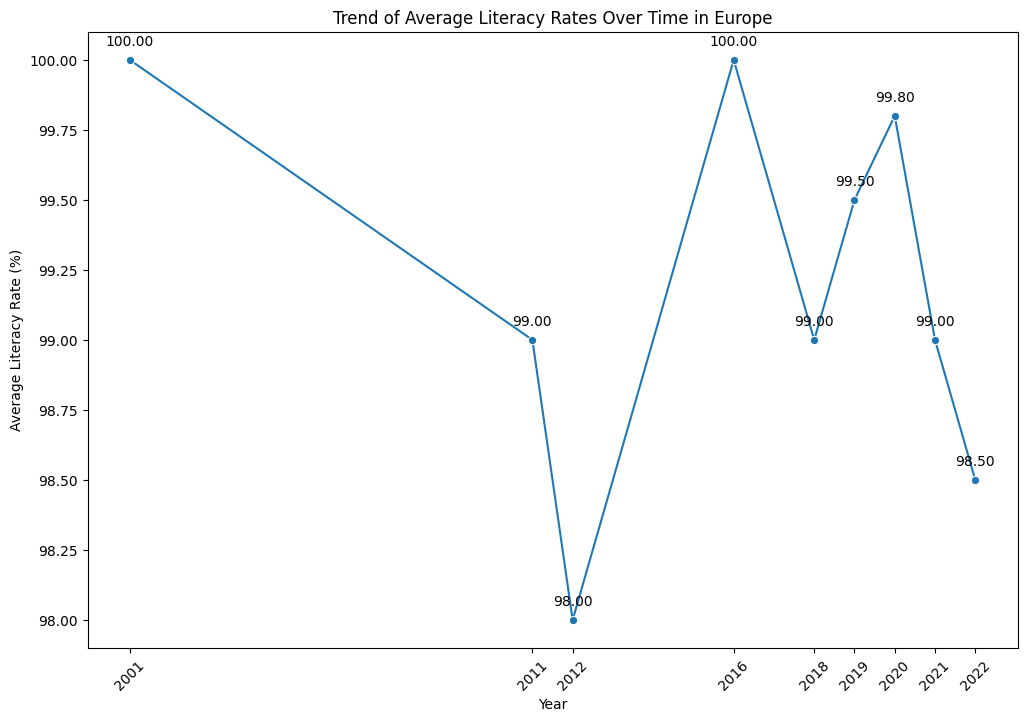

In [ ]:
# Filter data for Europe
europe_df = main_df[main_df['Continent'] == 'Europe']

# Calculate average literacy rate per year for Europe
europe_avg_literacy = europe_df.groupby('Year')['Literacy Rate'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=europe_avg_literacy, x='Year', y='Literacy Rate', marker='o')
lineplot.set_title('Trend of Average Literacy Rates Over Time in Europe')
lineplot.set_xlabel('Year')
lineplot.set_ylabel('Average Literacy Rate (%)')
lineplot.set_xticks(europe_avg_literacy['Year'].unique())
lineplot.set_xticklabels(europe_avg_literacy['Year'].unique(), rotation=45)

# Add labels
for x, y in zip(europe_avg_literacy['Year'], europe_avg_literacy['Literacy Rate']):
    plt.text(x, y + 0.05, f'{y:.2f}', ha='center')

plt.show()

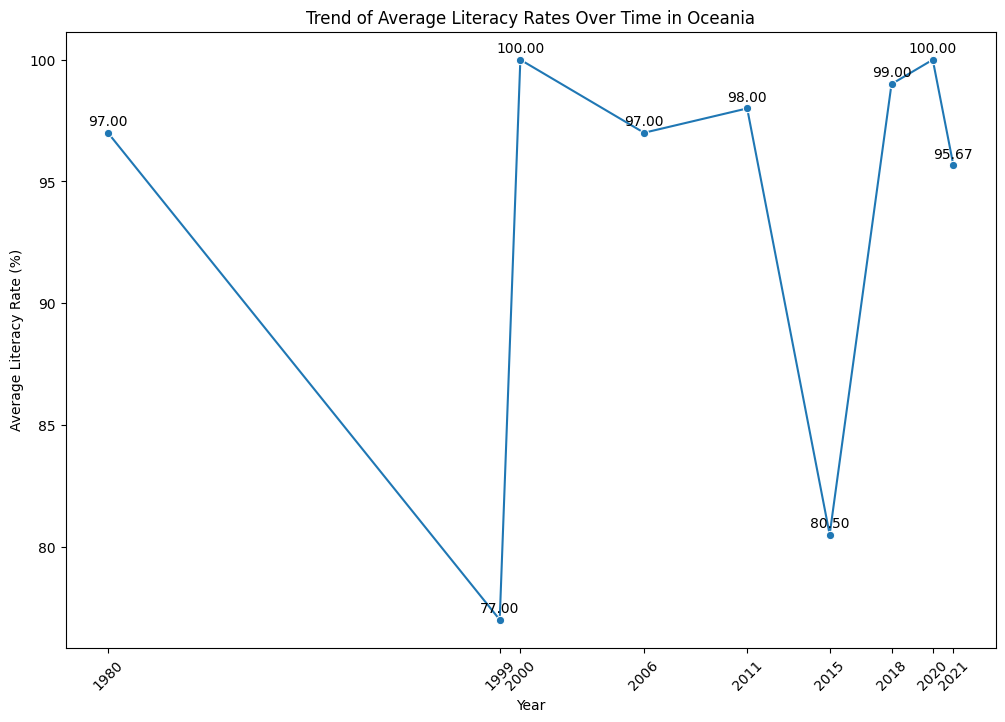

In [ ]:
# Filter data for Oceania
oceania_df = main_df[main_df['Continent'] == 'Oceania']

# Calculate average literacy rate per year for Oceania
oceania_avg_literacy = oceania_df.groupby('Year')['Literacy Rate'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 8))
lineplot = sns.lineplot(data=oceania_avg_literacy, x='Year', y='Literacy Rate', marker='o')
lineplot.set_title('Trend of Average Literacy Rates Over Time in Oceania')
lineplot.set_xlabel('Year')
lineplot.set_ylabel('Average Literacy Rate (%)')
lineplot.set_xticks(oceania_avg_literacy['Year'].unique())
lineplot.set_xticklabels(oceania_avg_literacy['Year'].unique(), rotation=45)

# Add labels
for x, y in zip(oceania_avg_literacy['Year'], oceania_avg_literacy['Literacy Rate']):
    plt.text(x, y + 0.3, f'{y:.2f}', ha='center')

plt.show()

<ipython-input-16-3e885df1e5a2>:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


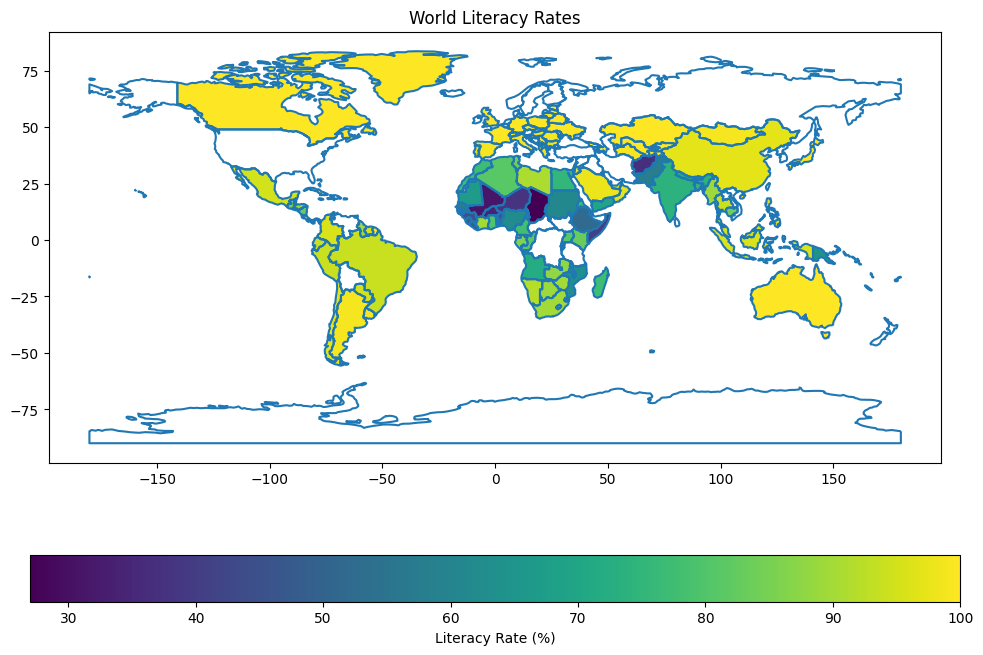

In [16]:
# Load the world map shapefile
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge the literacy rate data with the world map
merged = world.merge(main_df, how='left', left_on='name', right_on='Country')

# Plotting
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.boundary.plot(ax=ax)
merged.plot(column='Literacy Rate', ax=ax, legend=True,
            legend_kwds={'label': "Literacy Rate (%)",
                         'orientation': "horizontal"})

plt.title('World Literacy Rates')
plt.show()

In [17]:
# Create a choropleth map
fig = px.choropleth(main_df, locations="Country",
                    locationmode='country names',
                    color="Literacy Rate",
                    hover_name="Country",
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title="World Literacy Rates")

fig.update_geos(projection_type="natural earth")
fig.update_layout(coloraxis_colorbar=dict(title="Literacy Rate (%)"))
fig.show()